In [ ]:
import tensorflow as tf
import os
import random
import numpy as np

## 1. Criação de uma SEED

SEED = 0

def criar_seed(seed=SEED):
  os.environ['PYTHONHASHSEED'] = str(seed) # Controla aleatoriedade interna do interpretador Python
  random.seed(seed) # Controla aleatoriedade da biblioteca random
  np.random.seed(seed) # Controla aleatoriedade do NumPy
  tf.random.set_seed(seed) # Controla aleatoriedade do TensorFlow (pesos, embaralhamento, etc)

def setar_deterministico(seed=SEED): # Garantir que se obtenha os mesmos valores ao rodar o código novamente
  criar_seed(seed=seed) # Setar as seeds
  os.environ['TF_DETERMINISTIC_OPS'] = '1' # Força o TensorFlow a usar operações determinísticas
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # Força operações determinísticas específicas da GPU (cuDNN)
  tf.config.threading.set_inter_op_parallelism_threads(1) # Limita o paralelismo entre operações a 1 thread
  tf.config.threading.set_intra_op_parallelism_threads(1) # Limita o paralelismo dentro de cada operação a 1 thread

setar_deterministico(SEED)  # Executa tudo acima com a seed escolhida


In [ ]:
## Bibliotecas

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from keras.models import load_model
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

import joblib

In [ ]:
## Carregando Informações da PETR3

acao = 'ABEV3'

modelo_base = load_model('Modelo_VALE3.keras')
modelo_base.compile(optimizer='adam', loss='mse')

X_train = np.load(f'X_train_{acao}.npy')
y_train = np.load(f'y_train_{acao}.npy')
X_test = np.load(f'X_test_{acao}.npy')
y_test = np.load(f'y_test_{acao}.npy')
y_real = np.load(f'y_real_{acao}.npy')
scaler = joblib.load(f'scaler_{acao}.pkl')

In [ ]:

## Aplicação do Transfer Learning + Treinamento

modelo_transferido = modelo_base

modelo_transferido.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 7.1774e-04 - val_loss: 3.1804e-04
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.7119e-04 - val_loss: 3.1746e-04
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.5776e-04 - val_loss: 3.2932e-04
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.5177e-04 - val_loss: 3.4016e-04
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.4663e-04 - val_loss: 3.4686e-04
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.4256e-04 - val_loss: 3.5042e-04
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3933e-04 - val_loss: 3.5231e-04
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3670e-04 - val_loss: 3.5328e-04
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.3446e-04 - val_loss: 3.5372e-04
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.3250e-04 - val_loss: 3.5388e-04
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.3075e-0

In [ ]:
## Predição e Desnormalização

y_pred = modelo_transferido.predict(X_test)

y_pred_real = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((len(y_pred), scaler.n_features_in_ - 1))], axis=1))[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [ ]:

## Métricas

print("MAE:", mean_absolute_error(y_real, y_pred_real))
print("MAPE:", mean_absolute_percentage_error(y_real, y_pred_real))
print("R²:", r2_score(y_real, y_pred_real))

MAE: 0.1348104829810728
MAPE: 0.011360249598008392
R²: 0.9667769060880101


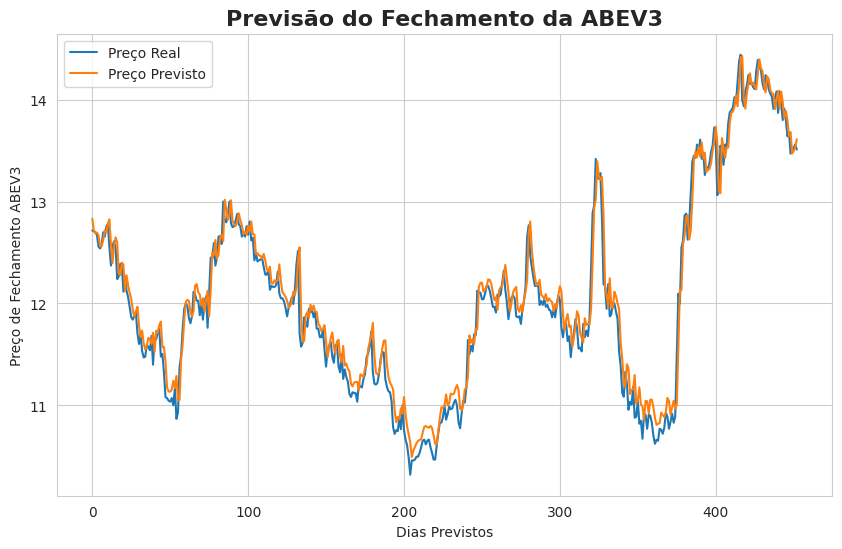

In [ ]:

## Gráfico

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
plt.plot(y_real, label='Preço Real')
plt.plot(y_pred_real, label='Preço Previsto')
plt.xlabel('Dias Previstos')
plt.ylabel(f'Preço de Fechamento {acao}')
plt.title(f'Previsão do Fechamento da {acao}', fontweight='bold', fontsize=16)
plt.legend()
plt.show()

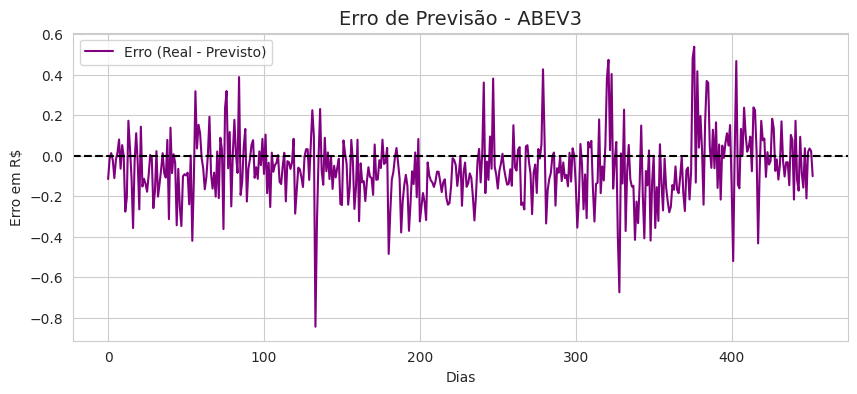

In [ ]:

plt.figure(figsize=(10, 4))
sns.set_style('whitegrid')

erro = y_real.flatten() - y_pred_real.flatten()  # Garante que são vetores 1D

plt.plot(erro, label='Erro (Real - Previsto)', color='purple')
plt.axhline(0, color='black', linestyle='--')

plt.title(f'Erro de Previsão - {acao}', fontsize=14)
plt.xlabel('Dias')
plt.ylabel('Erro em R$')
plt.legend()
plt.show()


In [ ]:
modelo_transferido.save('Modelo_ABEV3.keras', save_format='keras')

In [ ]:
modelo_transferido.save('Modelo_ABEV3.h5')